In [ ]:
import pandas as pd
import os
import plotly.express as px
import plotly.io as pio

# comment out this line for interactive plots
#   - this makes it easy to look at on github
pio.renderers.default = 'png'

# Preview the raw data and explore structure

View the basic structure of the data to figure out a way to load it into a pandas dataframe.

In [2]:
!head ../data/raw/users.dat

1::F::1::10::48067
2::M::56::16::70072
3::M::25::15::55117
4::M::45::7::02460
5::M::25::20::55455
6::F::50::9::55117
7::M::35::1::06810
8::M::25::12::11413
9::M::25::17::61614
10::F::35::1::95370


In [3]:
!head ../data/raw/ratings.dat

1::1193::5::978300760
1::661::3::978302109
1::914::3::978301968
1::3408::4::978300275
1::2355::5::978824291
1::1197::3::978302268
1::1287::5::978302039
1::2804::5::978300719
1::594::4::978302268
1::919::4::978301368


In [4]:
!head ../data/raw/movies.dat

1::Toy Story (1995)::Animation|Children's|Comedy
2::Jumanji (1995)::Adventure|Children's|Fantasy
3::Grumpier Old Men (1995)::Comedy|Romance
4::Waiting to Exhale (1995)::Comedy|Drama
5::Father of the Bride Part II (1995)::Comedy
6::Heat (1995)::Action|Crime|Thriller
7::Sabrina (1995)::Comedy|Romance
8::Tom and Huck (1995)::Adventure|Children's
9::Sudden Death (1995)::Action
10::GoldenEye (1995)::Action|Adventure|Thriller


# File structures and column names

The contain `::` separated fields. The columns are not obvious, but the [original source](https://files.grouplens.org/datasets/movielens/ml-1m-README.txt) provides explanation.

The columns in

  - user.dat    are `UserID::Gender::Age::Occupation::Zip-code`
    - where gender is `F` or `M`
    - and age is on of `[1, 18, 25, 35, 45, 50, 56]` which divides the users into age groups
    - occupation is from the interval `[0,20]`, explanation prvided in the original source
  - movies.dat  are `MovieID::Title::Genres`
    - where genres are pipe-separated and are one of the listed categories in the original source
  - ratings.dat are `UserID::MovieID::Rating::Timestamp`
    - where ratings are on the interval `[1,5]` (stars count based, only whole numbers)


# Load the data

In [5]:
RAW_DATA_DIR = "../data/raw/"

users_file = os.path.join(RAW_DATA_DIR, "users.dat")
movies_file = os.path.join(RAW_DATA_DIR, "movies.dat")
ratings_file = os.path.join(RAW_DATA_DIR, "ratings.dat")

users = pd.read_csv(users_file, sep="::", engine="python",
                    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"])

# we need to use 'latin1' encoding, since the default 'utf-8' encoding does not work
movies = pd.read_csv(movies_file, sep="::", engine="python",
                     names=["MovieID", "Title", "Genres"], encoding="latin1")

ratings = pd.read_csv(ratings_file, sep="::", engine="python",
                      names=["UserID", "MovieID", "Rating", "Timestamp"])

# Basic info about the counts, duplicates, missing values and types of data

Gather some insights into how many unique users, movies and ratings we have. Do we have any duplicates? Are there any missing values?

In [6]:
# we can omit this since we get this information from df.info()
# print("---- shapes ----")
# print("# of rows and cols in users:", users.shape)
# print("# of rows and cols in ratings:", ratings.shape)
# print("# of rows and cols in movies:", movies.shape)

# are all the users properly identified? (do we have any duplicates?)
print("---- duplicates ----")
print("Number of duplicated user IDs:", users["UserID"].duplicated().sum())
print("Number of duplicated movie IDs:", movies["MovieID"].duplicated().sum())
print("Number of duplicated ratings:", ratings[["UserID", "MovieID"]].duplicated().sum())

# we can omit this since we get that information from df.info()
# print("---- missing ----")
# print("\tMissing values in users:\n", users.isnull().sum())
# print("\tMissing values in movies:\n", movies.isnull().sum())
# print("\tMissing values in ratings:\n", ratings.isnull().sum())

print("---- column types ----")
print("\t>> users column types <<")
print(users.info())
print("\t>> movies column types <<")
print(movies.info())
print("\t>> ratings column types <<")
print(ratings.info())

---- duplicates ----
Number of duplicated user IDs: 0
Number of duplicated movie IDs: 0
Number of duplicated ratings: 0
---- column types ----
	>> users column types <<
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB
None
	>> movies column types <<
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3883 entries, 0 to 3882
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   MovieID  3883 non-null   int64 
 1   Title    3883 non-null   object
 2   Genres   3883 non-null   object
dtypes: int64(1), object(2)
memory usage: 91.1+ KB
None
	>> ratings co

# Analyze the user base

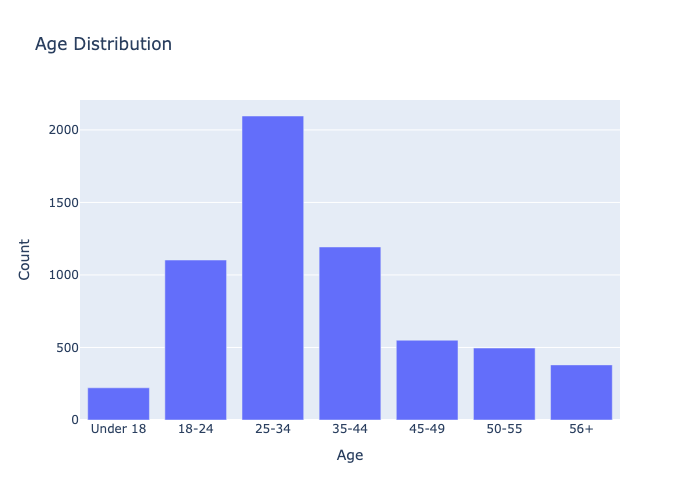

In [7]:
age_values = {
    1: "Under 18",
    18: "18-24",
    25: "25-34",
    35: "35-44",
    45: "45-49",
    50: "50-55",
    56: "56+"
}

age_counts = users['Age'].value_counts().sort_index()
fig = px.bar(x=age_counts.index.map(lambda age: age_values[age]), y=age_counts.values, title='Age Distribution', labels={'x': 'Age', 'y': 'Count'})
fig.show()

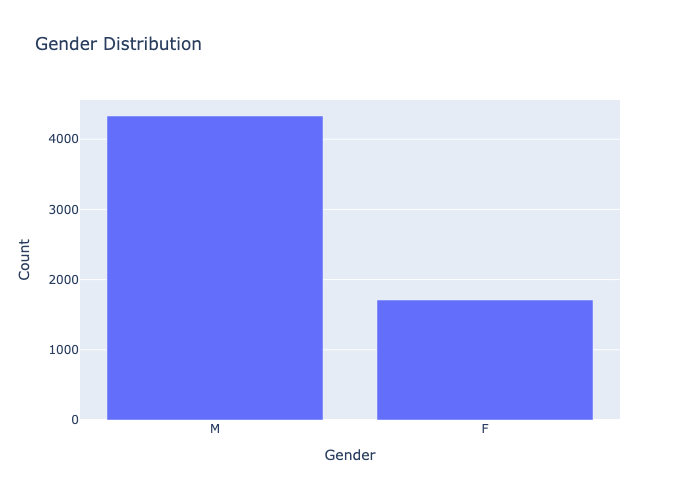

In [8]:
gender_counts = users["Gender"].value_counts()
fig = px.bar(x=gender_counts.index, y=gender_counts.values, title='Gender Distribution', labels={'x': 'Gender', 'y': 'Count'})
fig.show()

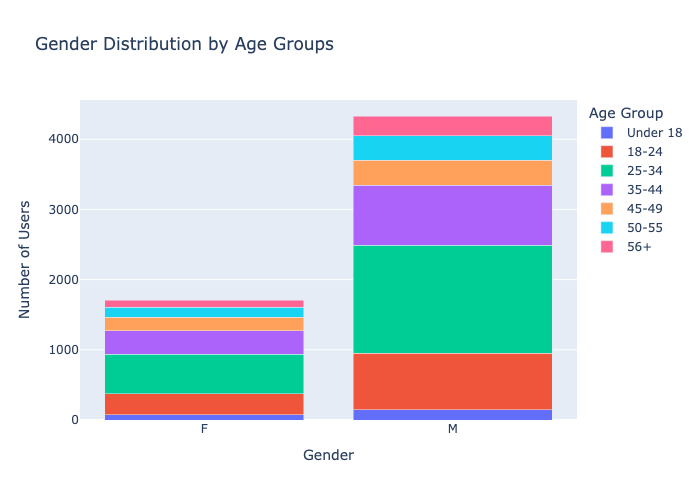

In [9]:
gender_age_counts = users.groupby(["Gender", "Age"]).size().reset_index(name="Count")
gender_age_counts["AgeGroup"] = gender_age_counts["Age"].map(age_values)

fig = px.bar(
    gender_age_counts,
    x="Gender",
    y="Count",
    color="AgeGroup",
    title="Gender Distribution by Age Groups",
    labels={"Count": "Number of Users", "AgeGroup": "Age Group"},
    barmode="stack"
)
fig.show()


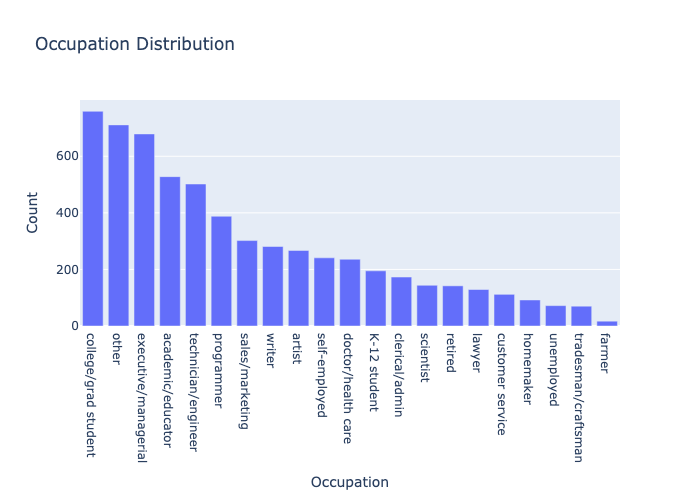

In [10]:
# from the README original source
occupation_mappings = {
    0: "other",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}
occupation_counts = users['Occupation'].map(occupation_mappings).value_counts()
fig = px.bar(x=occupation_counts.index, y=occupation_counts.values, title='Occupation Distribution', labels={'x': 'Occupation', 'y': 'Count'})
fig.show()

# Analysis of movies

  - how many ganres does a movie typically have?

In [11]:
movies.head() # to remember the structure

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


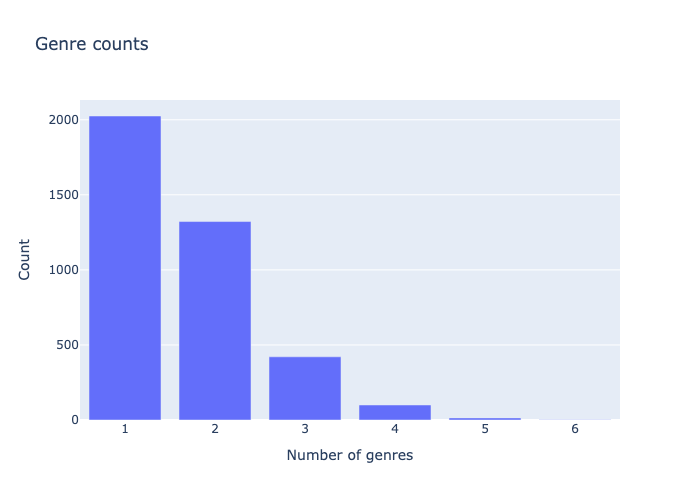

In [12]:
movie_genre_counts = movies['Genres'].map(lambda x: len(x.split('|')))
movie_genre_counts_explicit = movie_genre_counts.value_counts().reset_index(name="Count")#.set_index("Genres")
movie_genre_counts_explicit
fig = px.bar(movie_genre_counts_explicit,
        x="Genres",
        y="Count",
        title="Genre counts",
        labels={"Genres": "Number of genres", "Count": "Count"})
fig.show()


# Analysis of ratings
  - what is the distribution of ratings? Do users tend to prefer extremes (1 or 5) compared to the more neutral ratings?
  
## Analysis of movies when ratings are in the picutre
  - what are the most rated movies?
  - what are the highest/lowest rated movies?
  - what are the most rated genres?

   UserID  MovieID  Rating  Timestamp
0       1     1193       5  978300760
1       1      661       3  978302109
2       1      914       3  978301968
3       1     3408       4  978300275
4       1     2355       5  978824291


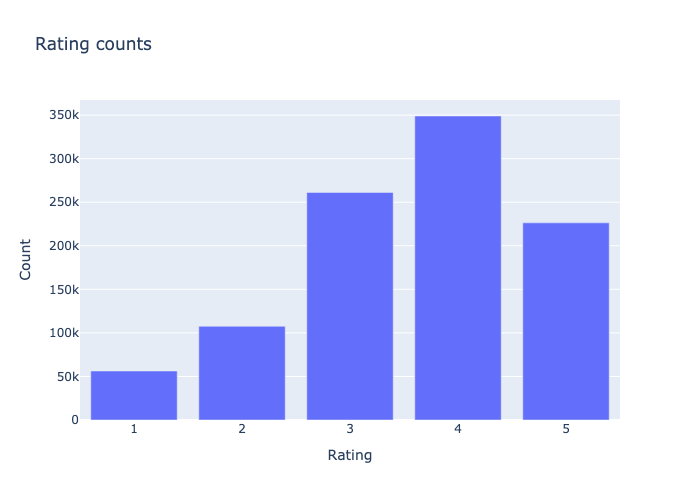

In [13]:
print(ratings.head())
ratings_distribution = ratings.groupby('Rating').count().reset_index("Rating")
ratings_distribution["Count"] = ratings_distribution["UserID"] # we can take a UserID, since we do not have any duplicates, that will be the count
ratings_distribution = ratings_distribution[["Rating", "Count"]]
ratings_distribution

fig = px.bar(ratings_distribution,
        x="Rating",
        y="Count",
        title="Rating counts")
fig.show()

In [14]:
# lets combine the datasets to analyze the other questions
df = ratings.merge(users, on="UserID").merge(movies, on="MovieID")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 10 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Timestamp   1000209 non-null  int64 
 4   Gender      1000209 non-null  object
 5   Age         1000209 non-null  int64 
 6   Occupation  1000209 non-null  int64 
 7   Zip-code    1000209 non-null  object
 8   Title       1000209 non-null  object
 9   Genres      1000209 non-null  object
dtypes: int64(6), object(4)
memory usage: 76.3+ MB


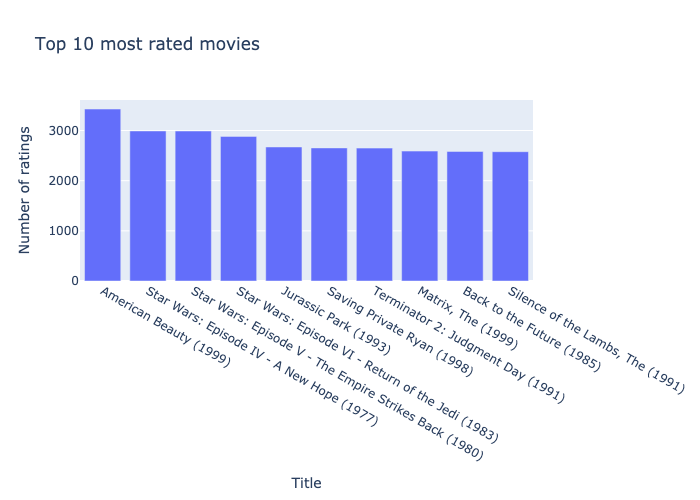

In [15]:
top_most_rated = df["Title"].value_counts()[:10]
fig = px.bar(
    top_most_rated,
    x=top_most_rated.index,
    y=top_most_rated.values,
    title="Top 10 most rated movies",
    labels={"x": "Title", "y": "Number of ratings"},
)
fig.show()

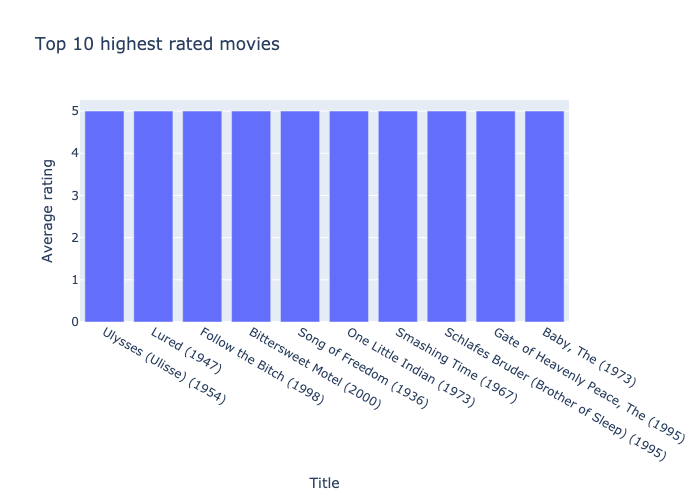

In [16]:
movie_ratings = df.groupby('Title')['Rating'].agg(['mean', 'count'])

highest_rated_movies = movie_ratings.sort_values(by='mean', ascending=False)
top_highest_rated_movies = highest_rated_movies.head(10)

fig = px.bar(
    x=top_highest_rated_movies.index,
    y=top_highest_rated_movies["mean"],
    title="Top 10 highest rated movies",
    labels={"x": "Title", "y": "Average rating"},
)
fig.show()

Since we get movies that only have 1 rating into the highest rated movies statistic, we'll change it up a bit. Let's  see the top highest rated movies that have at least 10 reviews.

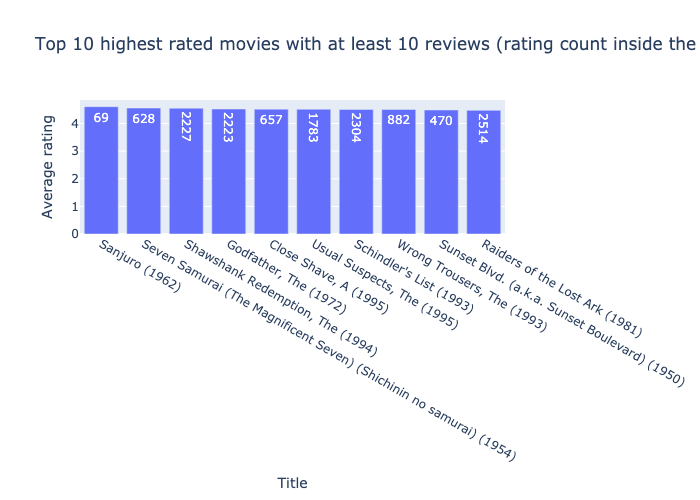

In [17]:
movie_ratings = df.groupby('Title')['Rating'].agg(['mean', 'count'])

filtered_rated_movies = movie_ratings[movie_ratings['count'] >= 10]
filtered_highest_rated_movies = filtered_rated_movies.sort_values(by='mean', ascending=False)
top_filtered_highest_rated_movies = filtered_highest_rated_movies.head(10)
fig = px.bar(
    x=top_filtered_highest_rated_movies.index,
    y=top_filtered_highest_rated_movies["mean"],
    title="Top 10 highest rated movies with at least 10 reviews (rating count inside the bars)",
    labels={"x": "Title", "y": "Average rating"},
)
fig.update_traces(text=top_filtered_highest_rated_movies["count"], textposition='auto')

fig.show()

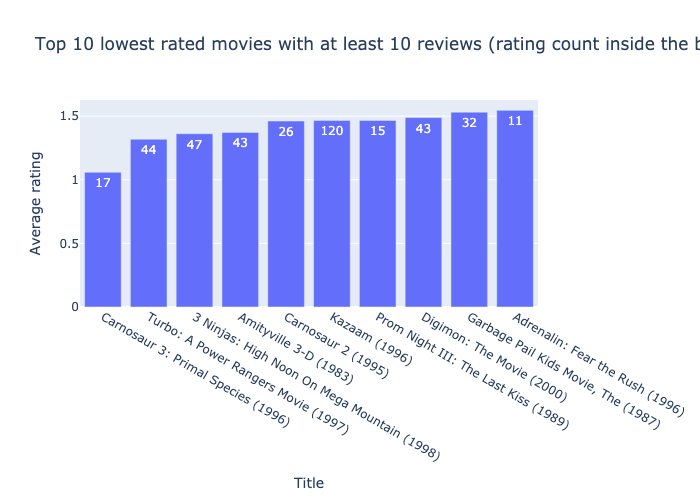

In [18]:
# lets also see the lowest rated movies with at least 10 ratings
filtered_lowest_rated_movies = filtered_rated_movies.sort_values(by='mean', ascending=True)
top_filtered_lowest_rated_movies = filtered_lowest_rated_movies.head(10)
fig = px.bar(
    x=top_filtered_lowest_rated_movies.index,
    y=top_filtered_lowest_rated_movies["mean"],
    title="Top 10 lowest rated movies with at least 10 reviews (rating count inside the bars)",
    labels={"x": "Title", "y": "Average rating"},
)
fig.update_traces(text=top_filtered_lowest_rated_movies["count"], textposition='auto')

fig.show()

#### Do movies with more ratings tend to have higher or lower ratings?

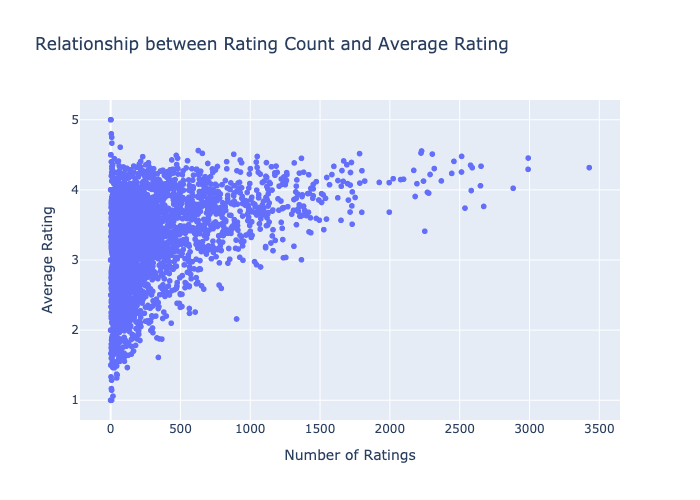

Correlation between the number of ratings and an average rating: 0.3579560372867074


In [19]:
fig = px.scatter(
    movie_ratings,
    x='count',
    y='mean',
    title='Relationship between Rating Count and Average Rating',
    labels={'count': 'Number of Ratings', 'mean': 'Average Rating'},
)
fig.show()

correlation = movie_ratings['count'].corr(movie_ratings['mean'])
print(f"Correlation between the number of ratings and an average rating: {correlation}")

# Insights into how ratings change over a certain time period

  - how do ratings change over the years?
  - what days do the users rate movies the most?


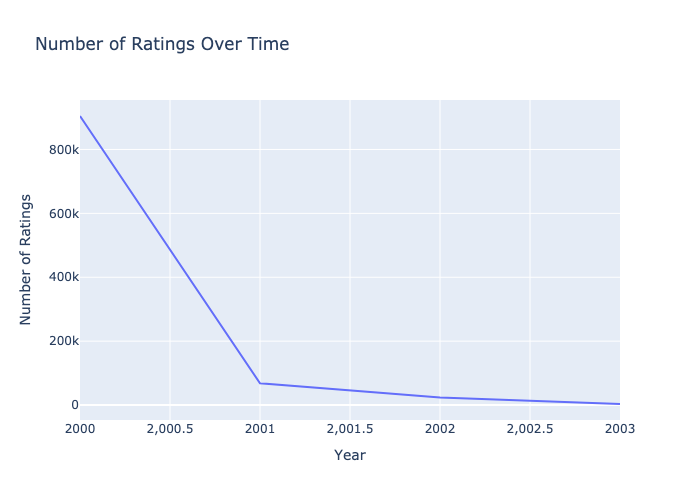

In [20]:
df['Datetime'] = pd.to_datetime(df['Timestamp'], unit='s')

# Extract Year
df['Year'] = df['Datetime'].dt.year

# Group by Year and count ratings
ratings_per_year = df['Year'].value_counts().sort_index()

# Plot using plotly
fig = px.line(
    x=ratings_per_year.index,
    y=ratings_per_year.values,
    title="Number of Ratings Over Time",
    labels={"x": "Year", "y": "Number of Ratings"},
)

fig.show()


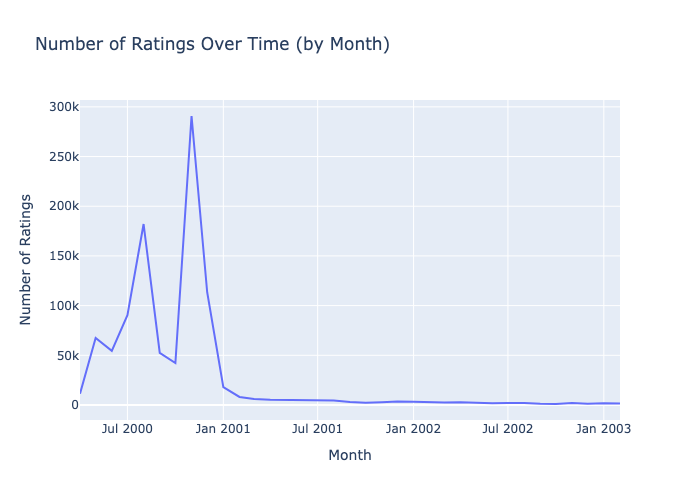

In [21]:
df['Year_Month'] = df['Datetime'].dt.to_period('M')
ratings_per_month = df['Year_Month'].value_counts().sort_index()
fig = px.line(
    x=ratings_per_month.index.astype(str),
    y=ratings_per_month.values,
    title="Number of Ratings Over Time (by Month)",
    labels={"x": "Month", "y": "Number of Ratings"},
)
fig.show()

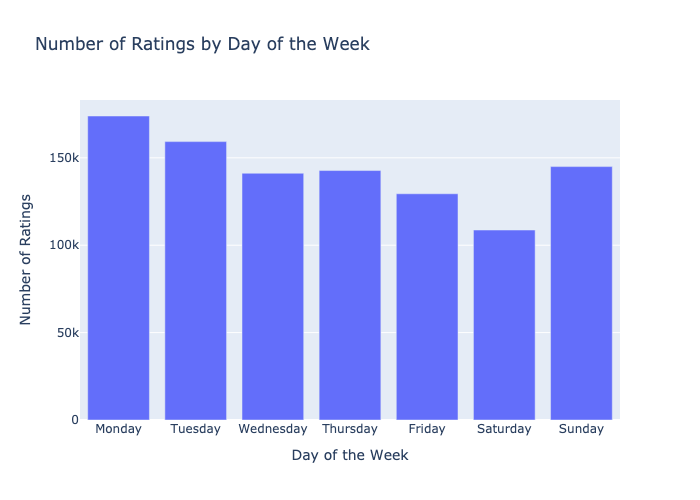

In [22]:
df['DayOfWeek'] = df['Datetime'].dt.day_name()

ratings_per_day = df['DayOfWeek'].value_counts()

days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ratings_per_day = ratings_per_day.reindex(days_of_week)
fig = px.bar(
    x=ratings_per_day.index,
    y=ratings_per_day.values,
    title="Number of Ratings by Day of the Week",
    labels={"x": "Day of the Week", "y": "Number of Ratings"},
)
fig.show()

In [23]:
ratings_per_user = df['UserID'].value_counts()

print("How many ratings do users do?")
print("Descriptive statistics:")
print(ratings_per_user.describe())

How many ratings do users do?
Descriptive statistics:
count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: count, dtype: float64
